In [684]:
import sys

sys.path.append("../")

import MetaTrader5 as mt5
import pytz
import numpy as np

from datetime import datetime
from terminal.Extensions.Mt5Helper import Mt5Helper

In [685]:
mt5.initialize()

True

In [686]:
from_date = datetime(2024, 5, 22, tzinfo=pytz.utc)
to_date = datetime(
    from_date.year, from_date.month, from_date.day, 23, 59, 59, 0, tzinfo=pytz.utc
)

In [687]:
data = mt5.copy_ticks_range("WINM24", from_date, to_date, mt5.COPY_TICKS_TRADE)

array([<Axes: xlabel='time_msc'>], dtype=object)

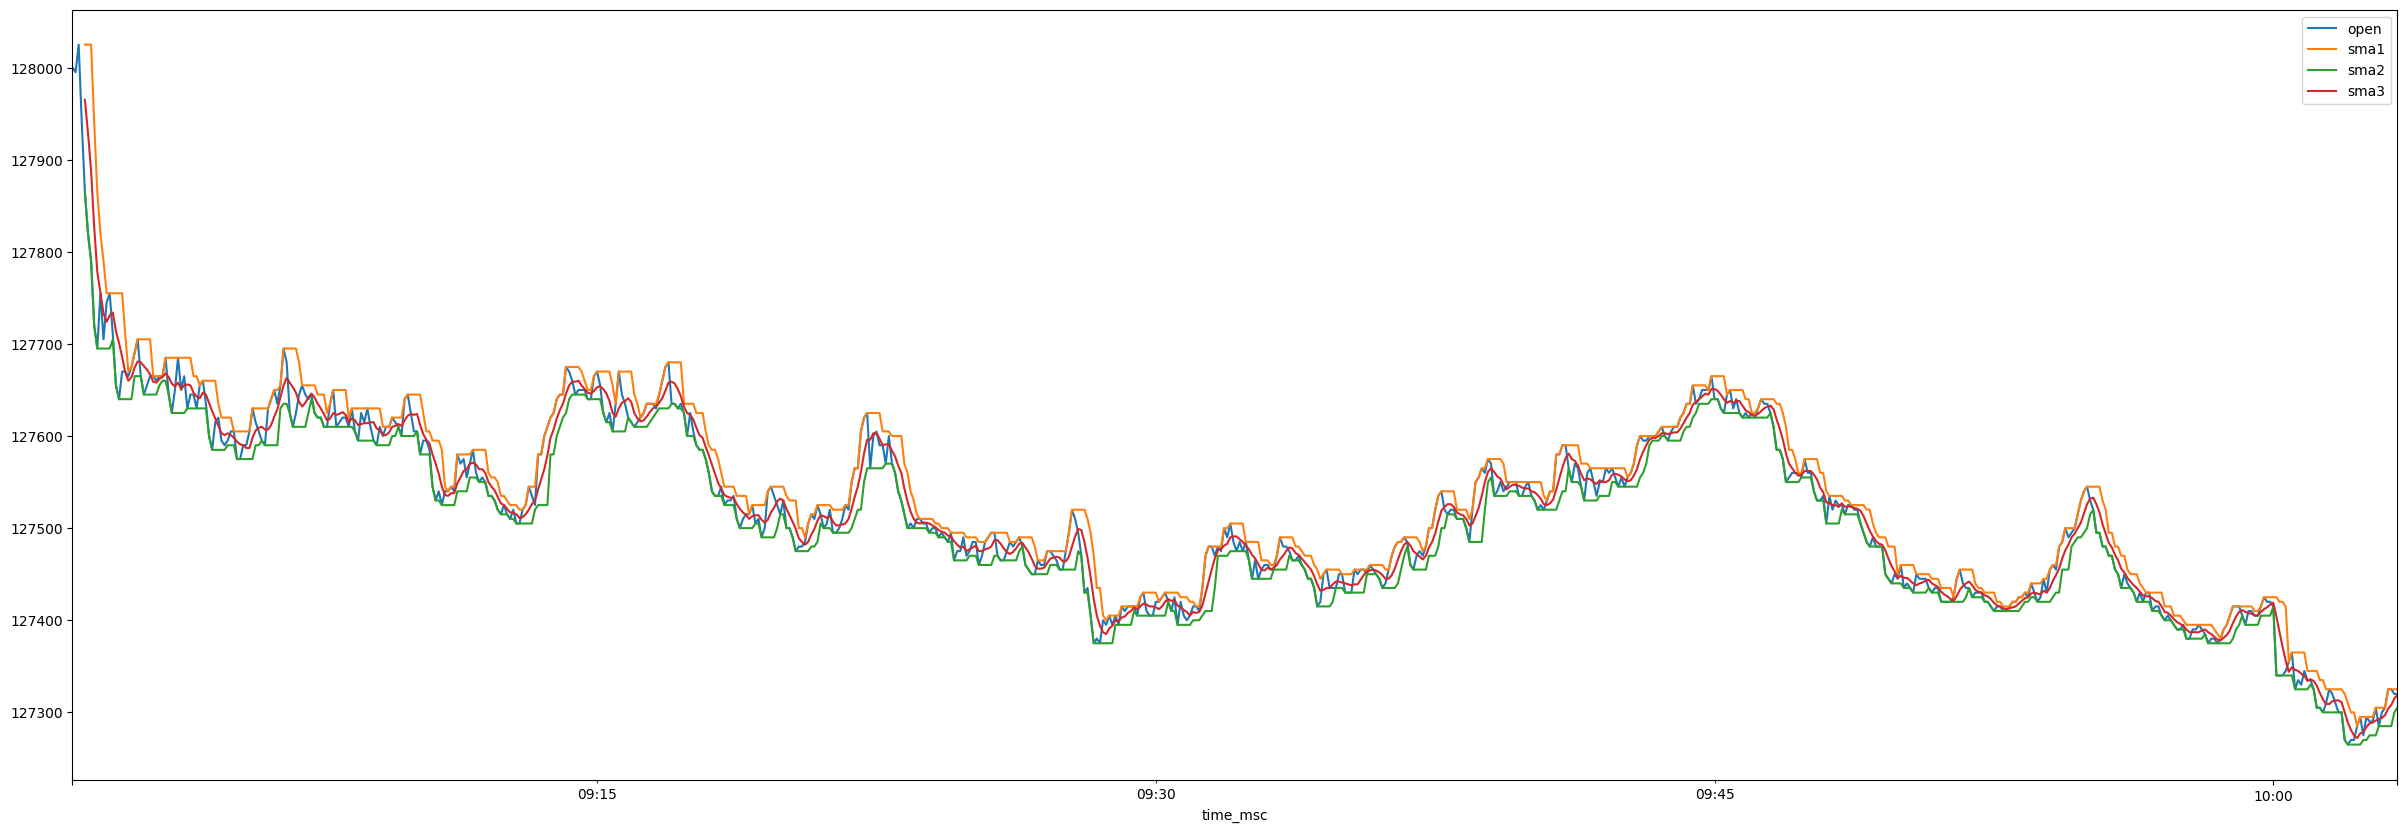

In [688]:
rates = Mt5Helper.OHLC(data, "5s")
rates.index = rates.index.tz_localize(None)
rates["sma1"] = rates["open"].rolling(5).max()
rates["sma2"] = rates["open"].rolling(5).min()
rates["sma3"] = rates["open"].rolling(5).mean()
rates["signal"] = rates["sma2"] + (rates["sma1"] - rates["sma2"]) / 2
rates.iloc[0:750][["open", "sma1", "sma2", "sma3"]].plot(
    kind="line", subplots=[("open", "sma1", "sma2", "sma3")], figsize=(30, 10)
)

<Axes: xlabel='time_msc'>

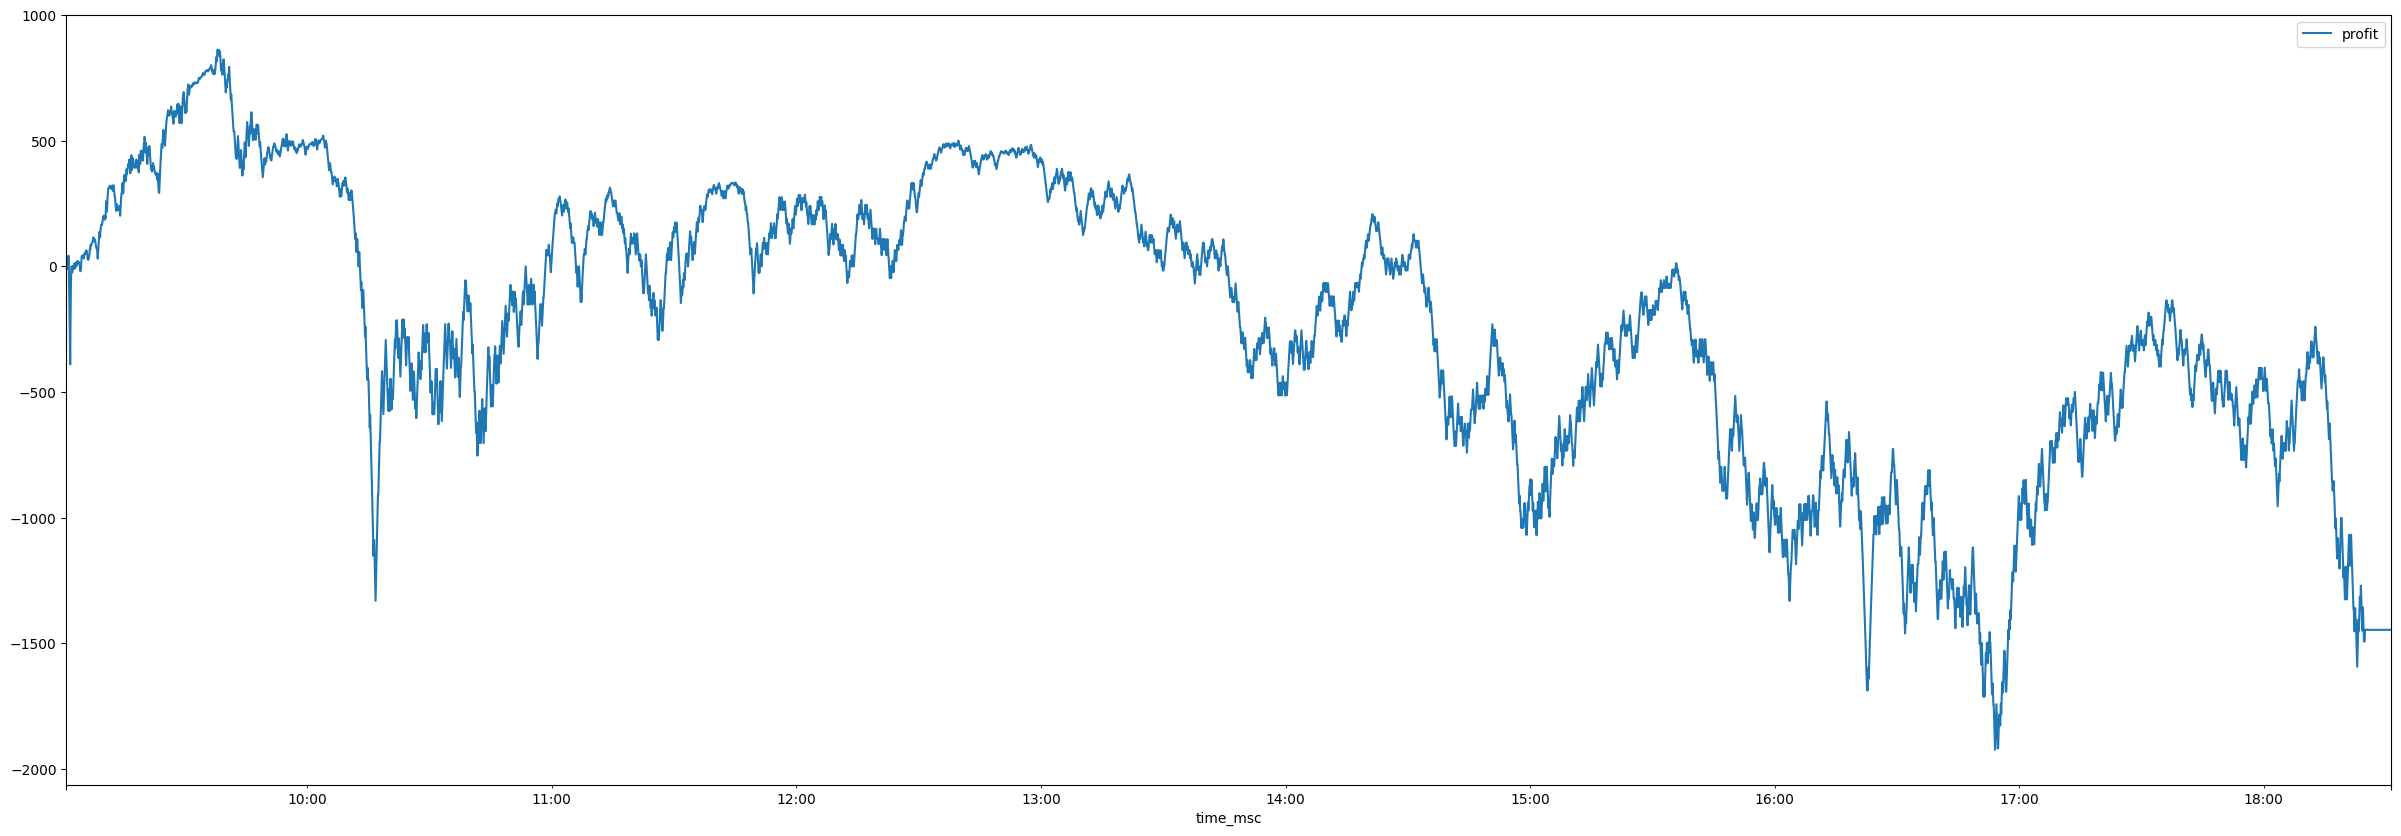

In [689]:
sum_buy = 0
sum_buy_qty = 0
buy_avg = 0
sum_sell = 0
sum_sell_qty = 0
sell_avg = 0
net_avg = 0
net_qty = 0
profit = 0
used_slippage = 0
slippage = 5


def update(i):
    rates.loc[i, "sum_buy"] = sum_buy
    rates.loc[i, "sum_buy_qty"] = sum_buy_qty
    rates.loc[i, "buy_avg"] = buy_avg
    rates.loc[i, "sum_sell"] = sum_sell
    rates.loc[i, "sum_sell_qty"] = sum_sell_qty
    rates.loc[i, "sell_avg"] = sell_avg
    rates.loc[i, "net_avg"] = net_avg
    rates.loc[i, "net_qty"] = net_qty
    rates.loc[i, "profit"] = profit
    rates.loc[i, "slippage"] = used_slippage


for i, item in rates.iterrows():
    if np.isnan(item.open) or np.isnan(item.signal):
        update(i)
        continue

    used_slippage = slippage

    d1 = item.sma1 - item.sma3 
    d2 = item.sma3 - item.sma2
    
    # sinal de compra
    if d1 > d2:
        sum_buy += item.open + used_slippage
        sum_buy_qty += 1

    # sinal de venda
    if d1 < d2:
        sum_sell += item.open - used_slippage
        sum_sell_qty -= 1

    buy_avg = 0 if sum_buy == 0 else sum_buy / sum_buy_qty
    sell_avg = 0 if sum_sell == 0 else sum_sell / sum_sell_qty

    buy = item.open + used_slippage if buy_avg == 0 else buy_avg
    sell = -item.open - used_slippage if sell_avg == 0 else sell_avg

    net_avg = sell + buy
    net_qty = sum_buy_qty + sum_sell_qty
    profit = net_avg * net_qty

    update(i)

rates[["profit"]].plot(figsize=(30, 10))

In [690]:
rates.to_excel("output.xlsx")